In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm  # Potentially for RESET Test or GAMs
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ticker-data/msft.csv
/kaggle/input/ticker-data/aapl.csv


In [2]:
# importing data in kaggle 
aapl = pd.read_csv("/kaggle/input/ticker-data/aapl.csv")
msft = pd.read_csv("/kaggle/input/ticker-data/msft.csv")
# Assign column names
aapl.columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction'] 
msft.columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction'] 

aapl.describe()

,Time,Type,Order ID,Size,Price,Direction
count,91996.000000,91996.000000,9.199600e+04,91996.000000,9.199600e+04,91996.000000
mean,35984.115223,2.124853,4.658716e+07,109.477738,5.858253e+06,-0.019044
std,978.774634,1.141645,1.734544e+07,182.425607,1.208740e+04,0.999824
min,34200.004261,1.000000,0.000000e+00,1.000000,4.770000e+06,-1.000000
25%,35180.475640,1.000000,3.467338e+07,20.000000,5.852700e+06,-1.000000
50%,36063.831945,3.000000,4.842785e+07,100.000000,5.859100e+06,-1.000000
75%,36749.345004,3.000000,6.112310e+07,100.000000,5.863800e+06,1.000000
max,37799.837447,5.000000,7.417768e+07,15000.000000,6.989500e+06,1.000000


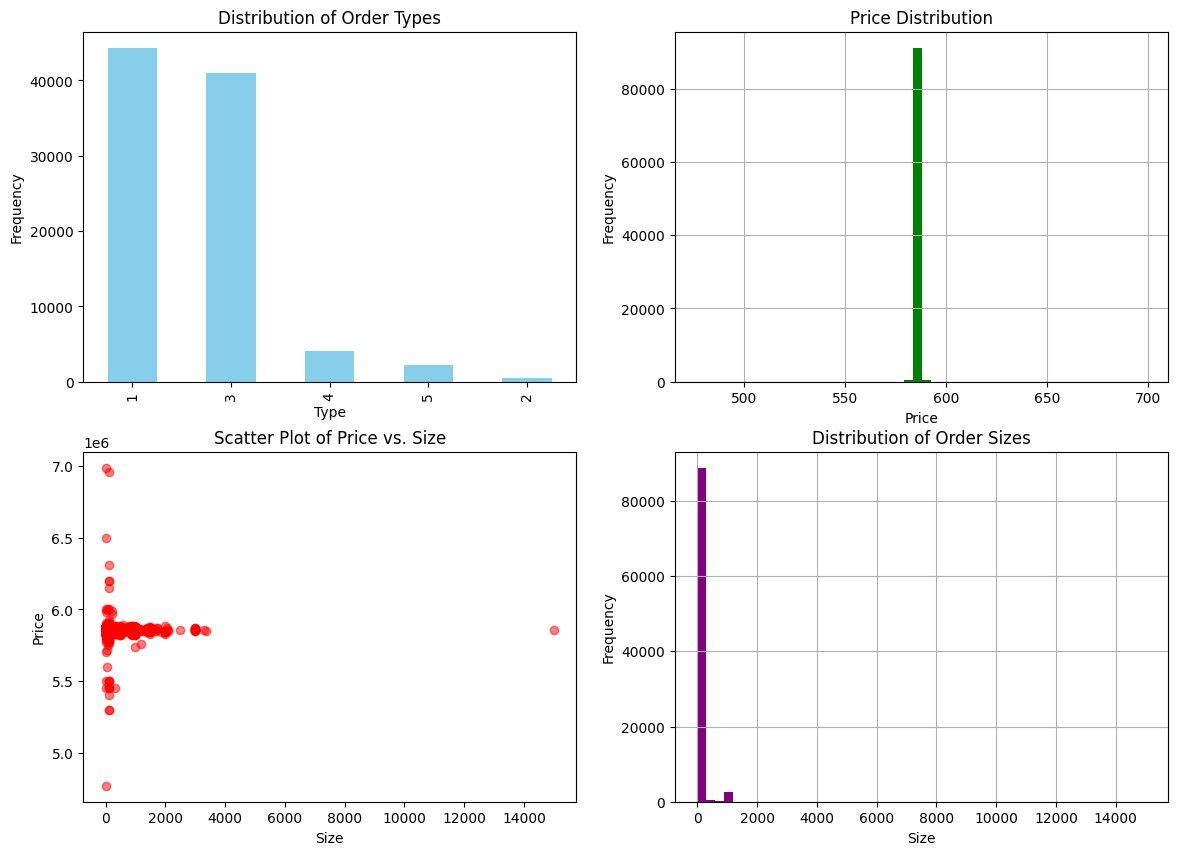

In [3]:
aapl['Adjusted Price'] = aapl['Price'] / 10000
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution of 'Type'
aapl['Type'].value_counts().plot(kind='bar', ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Distribution of Order Types')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Frequency')

# Plot 2: Price distribution
aapl['Adjusted Price'].hist(bins=50, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Price Distribution')
axs[0, 1].set_xlabel('Price')
axs[0, 1].set_ylabel('Frequency')

# Plot 3: Scatter plot of Price vs. Size
axs[1, 0].scatter(aapl['Size'], aapl['Price'], alpha=0.5, color='red')
axs[1, 0].set_title('Scatter Plot of Price vs. Size')
axs[1, 0].set_xlabel('Size')
axs[1, 0].set_ylabel('Price')

# Plot 4: Histogram of 'Size'
aapl['Size'].hist(bins=50, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Distribution of Order Sizes')
axs[1, 1].set_xlabel('Size')
axs[1, 1].set_ylabel('Frequency')

plt.savefig("aapl_exploration.png")


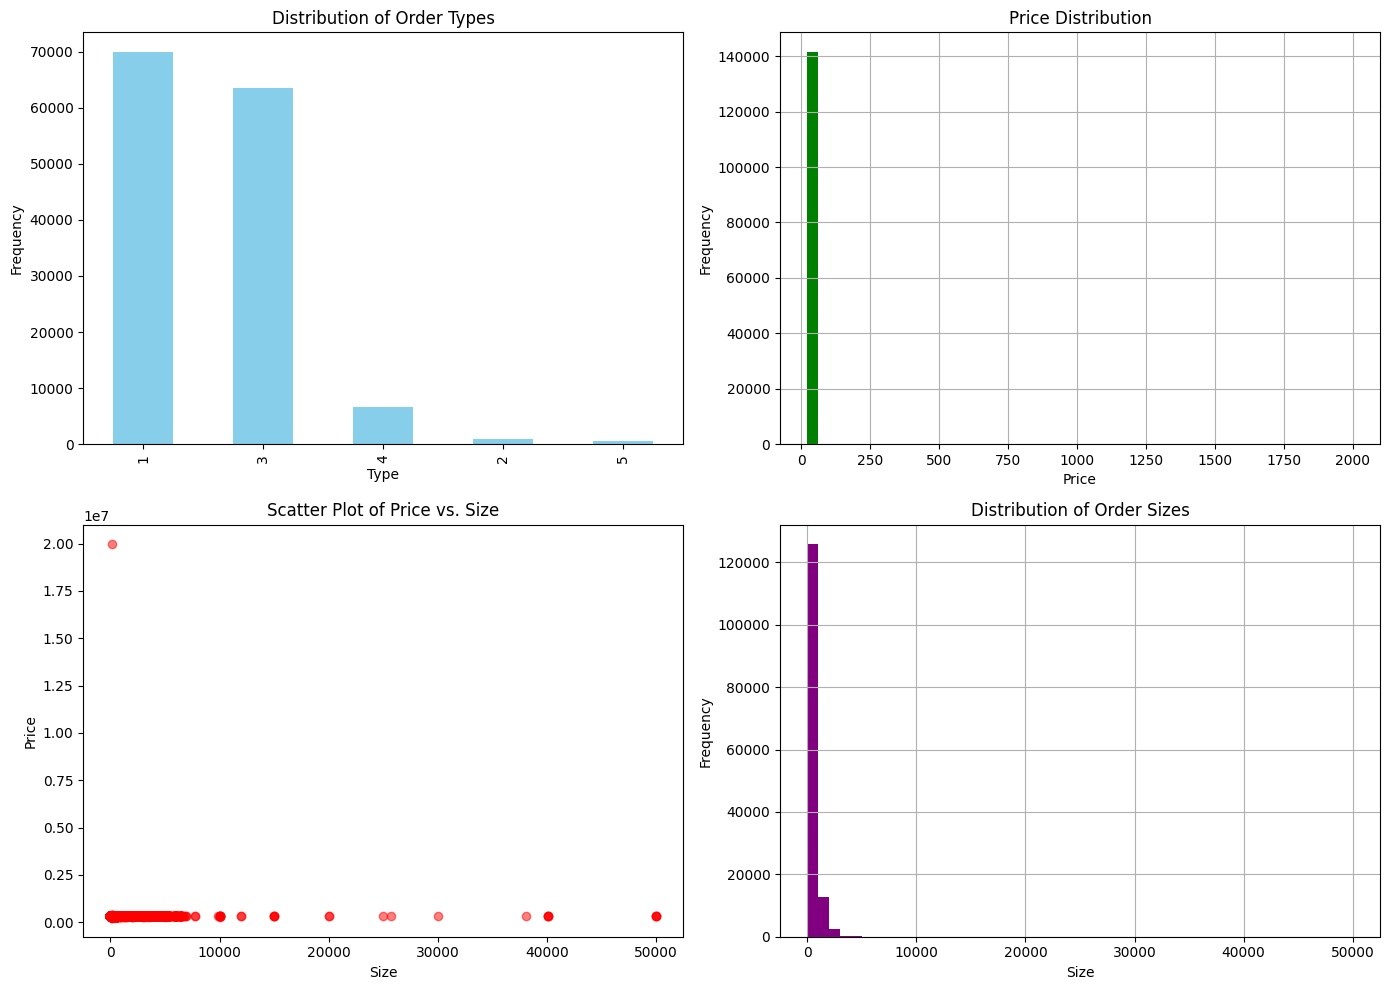

In [4]:
msft['Adjusted Price'] = msft['Price'] / 10000

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution of 'Type'
msft['Type'].value_counts().plot(kind='bar', ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Distribution of Order Types')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Frequency')

# Plot 2: Price distribution
msft['Adjusted Price'].hist(bins=50, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Price Distribution')
axs[0, 1].set_xlabel('Price')
axs[0, 1].set_ylabel('Frequency')

# Plot 3: Scatter plot of Price vs. Size
axs[1, 0].scatter(msft['Size'], msft['Price'], alpha=0.5, color='red')
axs[1, 0].set_title('Scatter Plot of Price vs. Size')
axs[1, 0].set_xlabel('Size')
axs[1, 0].set_ylabel('Price')

# Plot 4: Histogram of 'Size'
msft['Size'].hist(bins=50, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Distribution of Order Sizes')
axs[1, 1].set_xlabel('Size')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
## Transformation for AAPL: 
 
aapl_T = aapl.copy()

# Assuming 'Type' column exists and types 4 and 5 indicate an executed order
aapl_T['Executed'] = aapl_T['Type'].apply(lambda x: 1 if x in [4, 5] else 0)

date_from_file = '2012-06-21'  # Extracted from filename
aapl_T['DateTime'] = pd.to_datetime(aapl_T['Time'], unit='s', origin=pd.Timestamp(date_from_file))
aapl_T['Time_of_Day'] = aapl_T['DateTime'].dt.time

# Calculate milliseconds since market open at 9:30 AM
market_open_time = pd.Timestamp(date_from_file + ' 09:30:00')
aapl_T['Milliseconds_from_Open'] = (aapl_T['DateTime'] - market_open_time).dt.total_seconds() * 1000

# Create a rolling window count of orders in the last minute (60 seconds)
aapl_T = aapl_T.sort_values('DateTime')
aapl_T['Rolling_Num_Orders'] =aapl_T.rolling('60s', on='DateTime').count()['Time']

# Price Normalization
aapl_T['Normalized_Price'] = aapl_T['Price'] / 10000

# Size Transformation
aapl_T['Log_Size'] = np.log(aapl_T['Size'] + 1)

# One-Hot Encoding of Type
type_dummies = pd.get_dummies(aapl_T['Type'], prefix='Type')
aapl_T = aapl_T.join(type_dummies)

# Check for missing values and decide on a strategy to handle them
missing_values = aapl_T.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Time                      0
Type                      0
Order ID                  0
Size                      0
Price                     0
Direction                 0
Adjusted Price            0
Executed                  0
DateTime                  0
Time_of_Day               0
Milliseconds_from_Open    0
Rolling_Num_Orders        0
Normalized_Price          0
Log_Size                  0
Type_1                    0
Type_2                    0
Type_3                    0
Type_4                    0
Type_5                    0
dtype: int64


In [6]:
## Transformations on msft: 
msft_T = msft.copy()

# Assuming 'Type' column exists and types 4 and 5 indicate an executed order
msft_T['Executed'] = msft_T['Type'].apply(lambda x: 1 if x in [4, 5] else 0)
# Extracting date from filename and converting 'Time' to datetime
date_from_file = '2012-06-21'  # Extracted from filename
msft_T['DateTime'] = pd.to_datetime(msft_T['Time'], unit='s', origin=pd.Timestamp(date_from_file))
msft_T['Time_of_Day'] = msft_T['DateTime'].dt.time

# Calculate milliseconds since market open at 9:30 AM
market_open_time = pd.Timestamp(date_from_file + ' 09:30:00')
msft_T['Milliseconds_from_Open'] = (msft_T['DateTime'] - market_open_time).dt.total_seconds() * 1000

# Create a rolling window count of orders in the last minute (60 seconds)
msft_T = msft_T.sort_values('DateTime')
msft_T['Rolling_Num_Orders'] =msft_T.rolling('60s', on='DateTime').count()['Time']

# Price Normalization
msft_T['Normalized_Price'] = msft_T['Price'] / 10000

# Size Transformation
msft_T['Log_Size'] = np.log(msft_T['Size'] + 1)

# One-Hot Encoding of Type
type_dummies = pd.get_dummies(msft_T['Type'], prefix='Type')
msft_T = msft_T.join(type_dummies)

# Check for missing values and decide on a strategy to handle them
missing_values = msft_T.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Time                      0
Type                      0
Order ID                  0
Size                      0
Price                     0
Direction                 0
Adjusted Price            0
Executed                  0
DateTime                  0
Time_of_Day               0
Milliseconds_from_Open    0
Rolling_Num_Orders        0
Normalized_Price          0
Log_Size                  0
Type_1                    0
Type_2                    0
Type_3                    0
Type_4                    0
Type_5                    0
dtype: int64


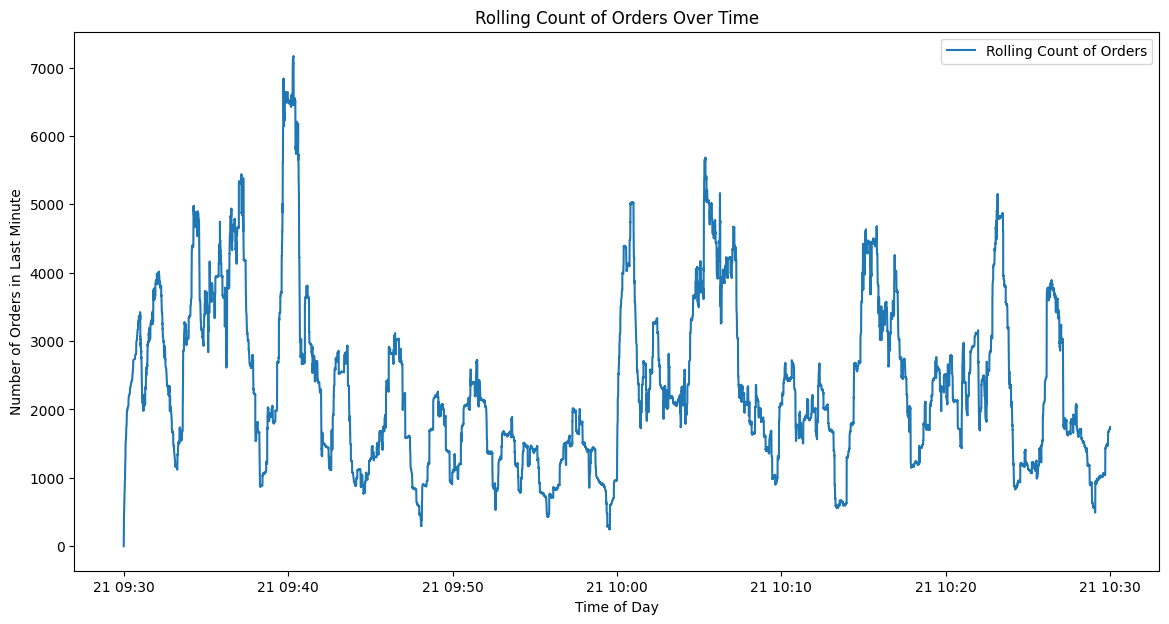

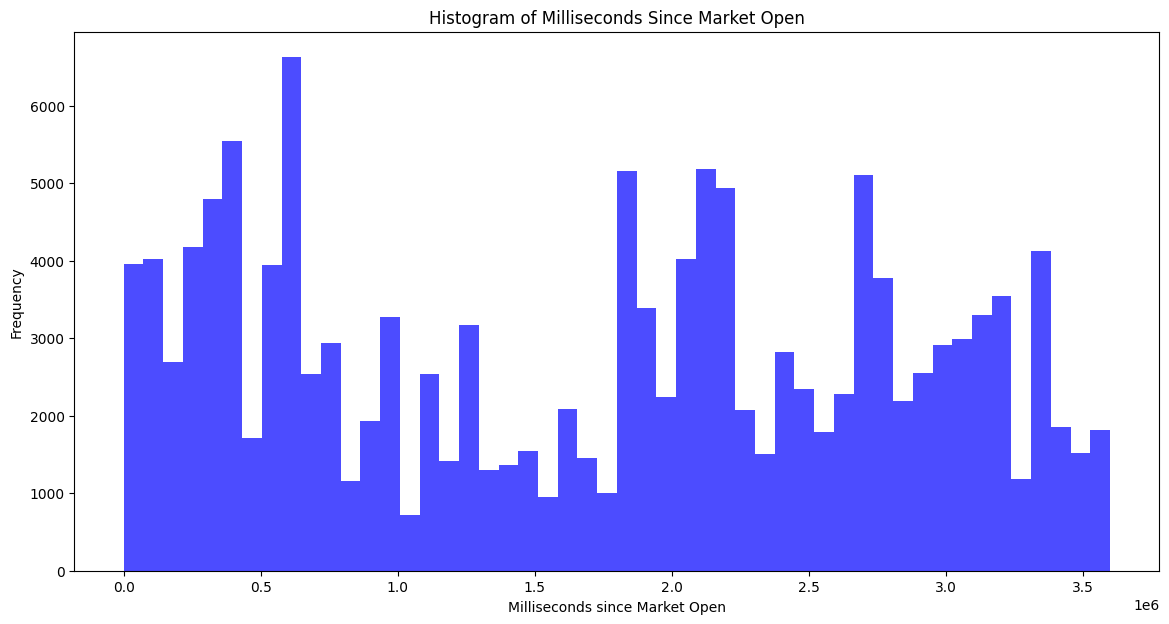

In [7]:
# Plot the rolling count of orders over time
plt.figure(figsize=(14, 7))
plt.plot(msft_T['DateTime'], msft_T['Rolling_Num_Orders'], label='Rolling Count of Orders')
plt.title('Rolling Count of Orders Over Time')
plt.xlabel('Time of Day')
plt.ylabel('Number of Orders in Last Minute')
plt.legend()
plt.show()

# Plot the histogram of milliseconds since market open
plt.figure(figsize=(14, 7))
plt.hist(msft_T['Milliseconds_from_Open'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Milliseconds Since Market Open')
plt.xlabel('Milliseconds since Market Open')
plt.ylabel('Frequency')
plt.show()



In [10]:
msft_T

,Time,Type,Order ID,Size,Price,Direction,Adjusted Price,Return,Executed,DateTime,Time_of_Day,Milliseconds_from_Open,Rolling_Num_Orders,Normalized_Price,Log_Size,Type_1,Type_2,Type_3,Type_4,Type_5
0,34200.013994,1,16116348,100,310500,-1,31.05,0.000000,0,2012-06-21 09:30:00.013994217,09:30:00.013994,1.399422e+01,1.0,31.05,4.615121,True,False,False,False,False
1,34200.015248,1,16116658,100,310400,-1,31.04,-0.000322,0,2012-06-21 09:30:00.015247822,09:30:00.015247,1.524782e+01,2.0,31.04,4.615121,True,False,False,False,False
2,34200.015442,1,16116704,100,310500,-1,31.05,0.000322,0,2012-06-21 09:30:00.015442133,09:30:00.015442,1.544213e+01,3.0,31.05,4.615121,True,False,False,False,False
3,34200.015789,1,16116752,100,310600,-1,31.06,0.000322,0,2012-06-21 09:30:00.015789032,09:30:00.015789,1.578903e+01,4.0,31.06,4.615121,True,False,False,False,False
4,34200.016300,1,16116815,100,310700,-1,31.07,0.000322,0,2012-06-21 09:30:00.016299485,09:30:00.016299,1.629949e+01,5.0,31.07,4.615121,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141501,37799.780171,1,74174637,330,308500,-1,30.85,0.000000,0,2012-06-21 10:29:59.780170918,10:29:59.780170,3.599780e+06,1738.0,30.85,5.802118,True,False,False,False,False
141502,37799.781628,3,74163313,330,308400,1,30.84,-0.000324,0,2012-06-21 10:29:59.781627655,10:29:59.781627,3.599782e+06,1739.0,30.84,5.802118,False,False,True,False,False
141503,37799.781778,3,74163417,80,308700,-1,30.87,0.000973,0,2012-06-21 10:29:59.781778336,10:29:59.781778,3.599782e+06,1740.0,30.87,4.394449,False,False,True,False,False
141504,37799.781979,1,74175260,80,308500,-1,30.85,-0.000648,0,2012-06-21 10:29:59.781979084,10:29:59.781979,3.599782e+06,1741.0,30.85,4.394449,True,False,False,False,False


In [10]:
aapl_T.dtypes

Time                             float64
Type                               int64
Order ID                           int64
Size                               int64
Price                              int64
Direction                          int64
Adjusted Price                   float64
Executed                           int64
DateTime                  datetime64[ns]
Time_of_Day                       object
Milliseconds_from_Open           float64
Rolling_Num_Orders               float64
Normalized_Price                 float64
Log_Size                         float64
Type_1                              bool
Type_2                              bool
Type_3                              bool
Type_4                              bool
Type_5                              bool
dtype: object

In [11]:
msft_T.head()

,Time,Type,Order ID,Size,Price,Direction,Adjusted Price,Return,Executed,DateTime,Time_of_Day,Milliseconds_from_Open,Rolling_Num_Orders,Normalized_Price,Log_Size,Type_1,Type_2,Type_3,Type_4,Type_5
0,34200.013994,1,16116348,100,310500,-1,31.05,0.000000,0,2012-06-21 09:30:00.013994217,09:30:00.013994,13.994217,1.0,31.05,4.615121,True,False,False,False,False
1,34200.015248,1,16116658,100,310400,-1,31.04,-0.000322,0,2012-06-21 09:30:00.015247822,09:30:00.015247,15.247822,2.0,31.04,4.615121,True,False,False,False,False
2,34200.015442,1,16116704,100,310500,-1,31.05,0.000322,0,2012-06-21 09:30:00.015442133,09:30:00.015442,15.442133,3.0,31.05,4.615121,True,False,False,False,False
3,34200.015789,1,16116752,100,310600,-1,31.06,0.000322,0,2012-06-21 09:30:00.015789032,09:30:00.015789,15.789032,4.0,31.06,4.615121,True,False,False,False,False
4,34200.016300,1,16116815,100,310700,-1,31.07,0.000322,0,2012-06-21 09:30:00.016299485,09:30:00.016299,16.299485,5.0,31.07,4.615121,True,False,False,False,False


In [12]:
aapl_T.describe()

,Time,Type,Order ID,Size,Price,Direction,Adjusted Price,Executed,DateTime,Milliseconds_from_Open,Rolling_Num_Orders,Normalized_Price,Log_Size
count,91996.000000,91996.000000,9.199600e+04,91996.000000,9.199600e+04,91996.000000,91996.000000,91996.000000,91996,9.199600e+04,91996.000000,91996.000000,91996.000000
mean,35984.115223,2.124853,4.658716e+07,109.477738,5.858253e+06,-0.019044,585.825293,0.068133,2012-06-21 09:59:44.115223040,1.784115e+06,1681.385169,585.825293,4.101158
min,34200.004261,1.000000,0.000000e+00,1.000000,4.770000e+06,-1.000000,477.000000,0.000000,2012-06-21 09:30:00.004260540,4.260540e+00,1.000000,477.000000,0.693147
25%,35180.475640,1.000000,3.467338e+07,20.000000,5.852700e+06,-1.000000,585.270000,0.000000,2012-06-21 09:46:20.475640576,9.804756e+05,1220.000000,585.270000,3.044522
50%,36063.831945,3.000000,4.842785e+07,100.000000,5.859100e+06,-1.000000,585.910000,0.000000,2012-06-21 10:01:03.831944704,1.863832e+06,1618.000000,585.910000,4.615121
75%,36749.345004,3.000000,6.112310e+07,100.000000,5.863800e+06,1.000000,586.380000,0.000000,2012-06-21 10:12:29.345004288,2.549345e+06,2066.000000,586.380000,4.615121
max,37799.837447,5.000000,7.417768e+07,15000.000000,6.989500e+06,1.000000,698.950000,1.000000,2012-06-21 10:29:59.837447166,3.599837e+06,3782.000000,698.950000,9.615872
std,978.774634,1.141645,1.734544e+07,182.425607,1.208740e+04,0.999824,1.208740,0.251976,NaN,9.787746e+05,638.283357,1.208740,1.144268


In [9]:
# Combine the datasets
combined_data = pd.concat([msft_T, aapl_T], ignore_index=True)

## Model 1: LogReg

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

features = [
    'Milliseconds_from_Open', 
    'Rolling_Num_Orders', 
    'Normalized_Price', 
    'Log_Size'
]
target = 'Executed'

X = combined_data[features]
y = combined_data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

log_reg_model = LogisticRegression()

log_reg_model.fit(X_train, y_train)

# Predicting on the model
y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Printing evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Extracting model coefficients
coef_df = pd.DataFrame(log_reg_model.coef_.flatten(), index=features, columns=['Coefficient'])
print("\nModel Coefficients:\n", coef_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     66079
           1       0.00      0.00      0.00      3972

    accuracy                           0.94     70051
   macro avg       0.47      0.50      0.49     70051
weighted avg       0.89      0.94      0.92     70051

Confusion Matrix:
 [[66079     0]
 [ 3972     0]]
ROC AUC Score: 0.6335933923700563

Model Coefficients:
                         Coefficient
Milliseconds_from_Open    -0.166182
Rolling_Num_Orders        -0.100984
Normalized_Price          -0.159025
Log_Size                  -0.470916


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(features))]

print(vif_data)

                  Feature       VIF
0  Milliseconds_from_Open  1.054150
1      Rolling_Num_Orders  1.029387
2        Normalized_Price  1.000381
3                Log_Size  1.026706


## Model 2: LogReg w/ weight parameter

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

features = [
    'Milliseconds_from_Open', 
    'Rolling_Num_Orders', 
    'Normalized_Price', 
    'Log_Size'
]
target = 'Executed'

X = aapl_T[features]
y = aapl_T[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Calculate class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Dictionary with the class weights
class_weights = {0: weights[0], 1: weights[1]}

weighted_log_reg_model = LogisticRegression(class_weight=class_weights)

weighted_log_reg_model.fit(X_train, y_train)

# Predictions
y_pred = weighted_log_reg_model.predict(X_test)

# Results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Coefficinets
coef_df = pd.DataFrame(weighted_log_reg_model.coef_.flatten(), index=features, columns=['Coefficient'])
print("\nModel Coefficients:\n", coef_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72     25763
           1       0.09      0.57      0.15      1836

    accuracy                           0.58     27599
   macro avg       0.52      0.57      0.43     27599
weighted avg       0.89      0.58      0.68     27599

Confusion Matrix:
 [[14818 10945]
 [  783  1053]]

Model Coefficients:
                         Coefficient
Milliseconds_from_Open    -0.198455
Rolling_Num_Orders        -0.016747
Normalized_Price           0.135864
Log_Size                  -0.221519


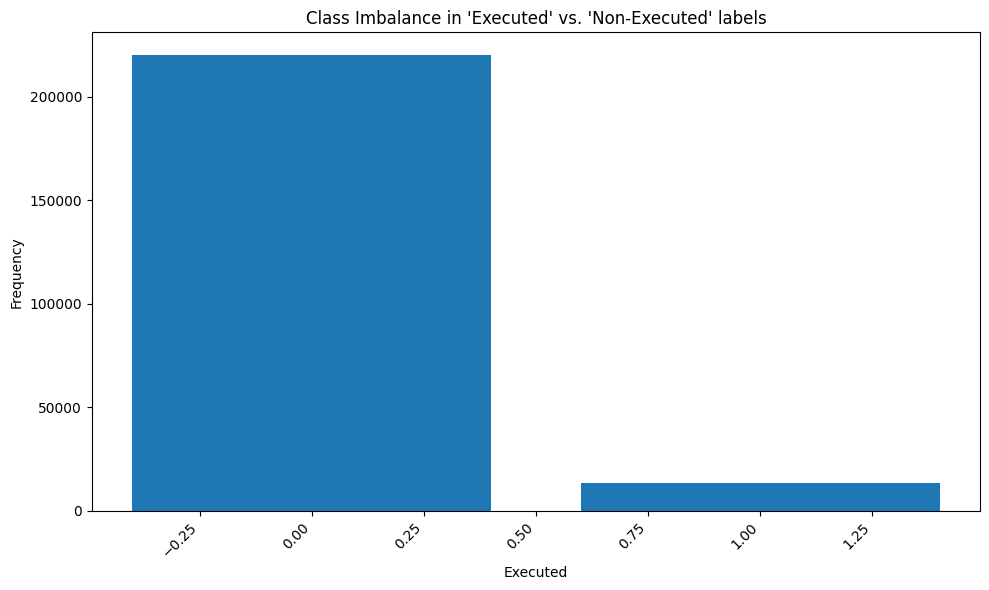

In [14]:
# Get frequency counts of unique values
value_counts = combined_data["Executed"].value_counts()


plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel(target_column)
plt.ylabel("Frequency")
plt.title(f"Class Imbalance in '{target_column}' vs. 'Non-Executed' labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Combine the datasets
combined_data = pd.concat([msft_T, aapl_T], ignore_index=True)

# Select relevant features based on prior models (XGBoost importance)
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

# Separate the features (X) and the target (y)
X = aapl_T[features]
y = aapl_T[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# Calculate class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize the logistic regression model with class_weight parameter
weighted_log_reg_model = LogisticRegression(class_weight=class_weights)

# Train the model
weighted_log_reg_model.fit(X_train, y_train)

# Predict on the test set and evaluate the model
y_pred = weighted_log_reg_model.predict(X_test)

# Print the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Displaying model coefficients for interpretation
coef_df = pd.DataFrame(weighted_log_reg_model.coef_.flatten(), index=features, columns=['Coefficient'])
print("\nModel Coefficients:\n", coef_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72     25763
           1       0.09      0.57      0.15      1836

    accuracy                           0.58     27599
   macro avg       0.52      0.57      0.43     27599
weighted avg       0.89      0.58      0.68     27599

Confusion Matrix:
 [[14818 10945]
 [  783  1053]]

Model Coefficients:
                         Coefficient
Milliseconds_from_Open    -0.198455
Rolling_Num_Orders        -0.016747
Normalized_Price           0.135864
Log_Size                  -0.221519


## Model 3: XGBoost : MSFT data

In [22]:
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = msft_T[features].values
y = msft_T[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Counts for the scale_pos_weight parameter
count_neg, count_pos = np.bincount(y_train)

xg_clf = xgb.XGBClassifier(scale_pos_weight=count_neg / count_pos)

# Train
xg_clf.fit(X_train, y_train)

# Prediction
y_pred = xg_clf.predict(X_test)
y_pred_proba = xg_clf.predict_proba(X_test)[:, 1]

# Results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     40337
           1       0.22      0.86      0.36      2115

    accuracy                           0.84     42452
   macro avg       0.61      0.85      0.63     42452
weighted avg       0.95      0.84      0.88     42452

Confusion Matrix:
 [[34046  6291]
 [  294  1821]]
ROC AUC Score: 0.9261388815775555


## Model 3: XGBoost w/ AAPL Data

In [15]:
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = aapl_T[features].values
y = aapl_T[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Counts for scale_pos_weight parameter
count_neg, count_pos = np.bincount(y_train)

aapl_xg_clf = xgb.XGBClassifier(scale_pos_weight=count_neg / count_pos)

# Train
aapl_xg_clf.fit(X_train, y_train)

# Prediction
y_pred = aapl_xg_clf.predict(X_test)
y_pred_proba = aapl_xg_clf.predict_proba(X_test)[:, 1]

# Results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     25727
           1       0.33      0.80      0.47      1872

    accuracy                           0.88     27599
   macro avg       0.66      0.84      0.70     27599
weighted avg       0.94      0.88      0.90     27599

Confusion Matrix:
 [[22659  3068]
 [  374  1498]]
ROC AUC Score: 0.9248249162225726


## Model 3: XGBoost with combined dataset

In [19]:

features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = combined_data[features].values
y = combined_data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Counts for the scale_pos_weight parameter
count_neg, count_pos = np.bincount(y_train)

combined_xg_clf = xgb.XGBClassifier(scale_pos_weight=count_neg / count_pos)

# Train
combined_xg_clf.fit(X_train, y_train)

# Prediction
y_pred = combined_xg_clf.predict(X_test)
y_pred_proba = combined_xg_clf.predict_proba(X_test)[:, 1]

# Results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89     66026
           1       0.22      0.81      0.34      4025

    accuracy                           0.82     70051
   macro avg       0.60      0.82      0.62     70051
weighted avg       0.94      0.82      0.86     70051

Confusion Matrix:
 [[54079 11947]
 [  746  3279]]
ROC AUC Score: 0.8992076394524047


In [20]:
# Feature importance from XGBoost
feature_importance = combined_xg_clf.feature_importances_
print("Feature Importances:", feature_importance)

# Evaluate XGBoost
xgb_predictions = combined_xg_clf.predict(X_test)
print(classification_report(y_test, xgb_predictions))


# Evaluating the model
print("Classification Report:\n", classification_report(y_test, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))

Feature Importances: [0.20673558 0.1391083  0.22656852 0.42758754]
              precision    recall  f1-score   support

           0       0.99      0.82      0.89     66026
           1       0.22      0.81      0.34      4025

    accuracy                           0.82     70051
   macro avg       0.60      0.82      0.62     70051
weighted avg       0.94      0.82      0.86     70051

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89     66026
           1       0.22      0.81      0.34      4025

    accuracy                           0.82     70051
   macro avg       0.60      0.82      0.62     70051
weighted avg       0.94      0.82      0.86     70051

Confusion Matrix:
 [[54079 11947]
 [  746  3279]]


#### AAPL XGBoost Summary Explainatory Plots

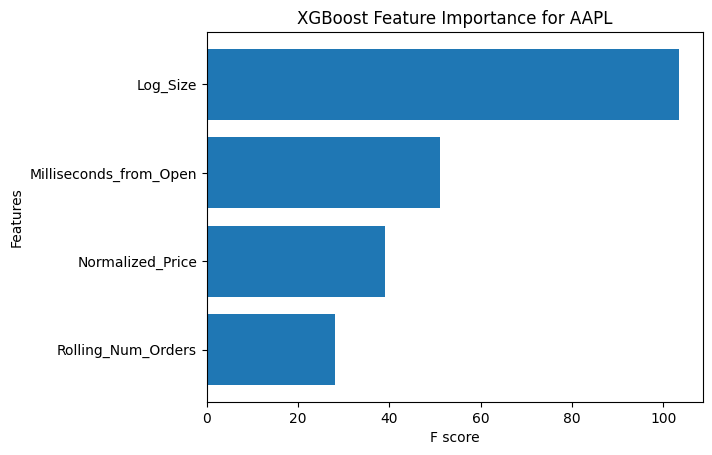

In [16]:
feature_importance = aapl_xg_clf.get_booster().get_score(importance_type='gain')
mapped_feature_importance = {features[int(k[1:])]: v for k, v in feature_importance.items()}
sorted_features = sorted(mapped_feature_importance.items(), key=lambda x: x[1], reverse=True)

sorted_feature_names = [x[0] for x in sorted_features]
sorted_feature_scores = [x[1] for x in sorted_features]

plt.barh(sorted_feature_names, sorted_feature_scores)
plt.xlabel('F score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance for AAPL')
plt.gca().invert_yaxis()
plt.show()


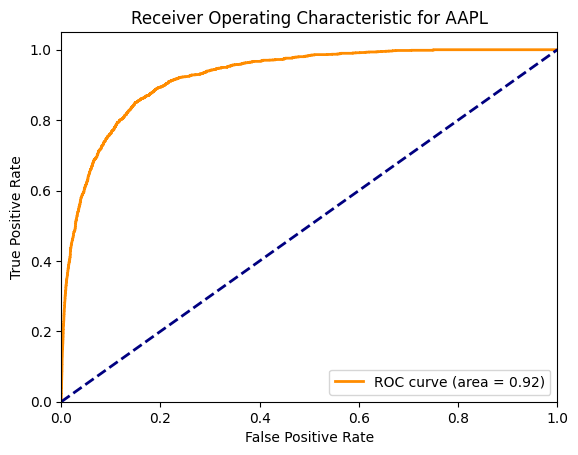

In [19]:
y_pred_proba = aapl_xg_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for AAPL')
plt.legend(loc="lower right")
plt.show()


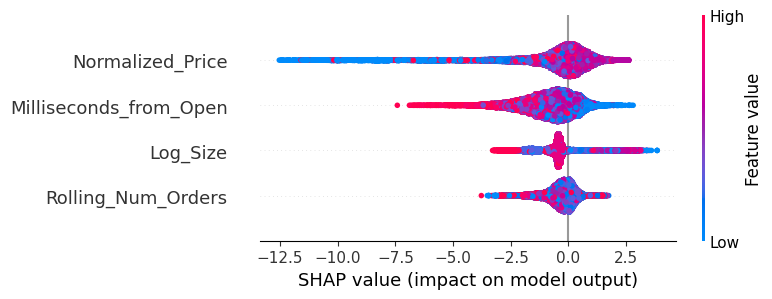

In [20]:
import shap

explainer = shap.Explainer(aapl_xg_clf)
shap_values = explainer(X)

# Shap plot
shap.summary_plot(shap_values, X, feature_names=features)

### MSFT XGBoost Explainatory Summary Plots

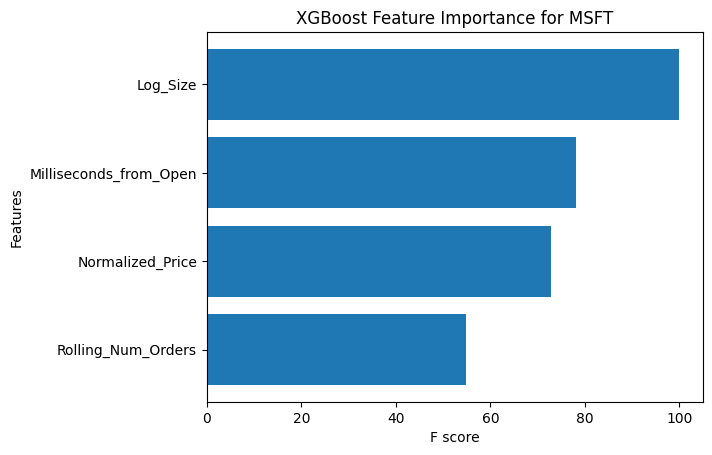

In [25]:
import matplotlib.pyplot as plt
import xgboost as xgb
feature_importance = xg_clf.get_booster().get_score(importance_type='gain')
mapped_feature_importance = {features[int(k[1:])]: v for k, v in feature_importance.items()}
sorted_features = sorted(mapped_feature_importance.items(), key=lambda x: x[1], reverse=True)


sorted_feature_names = [x[0] for x in sorted_features]
sorted_feature_scores = [x[1] for x in sorted_features]


plt.barh(sorted_feature_names, sorted_feature_scores)
plt.xlabel('F score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance for MSFT')
plt.gca().invert_yaxis()
plt.show()


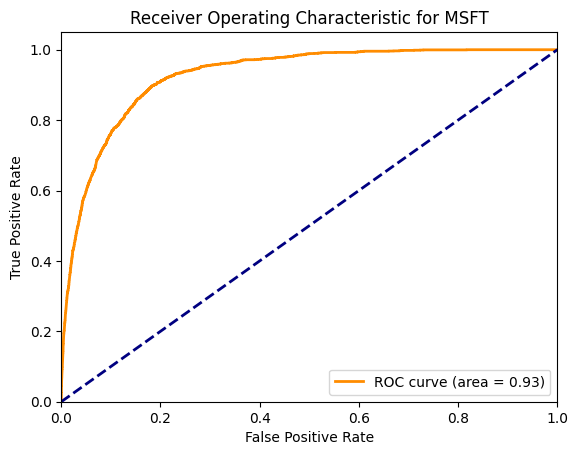

In [26]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = xg_clf.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for MSFT')
plt.legend(loc="lower right")
plt.show()


In [34]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# Set a random seed for reproducibility
random_seed = 42
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
cv_scores = cross_val_score(xg_clf, X, y, cv=stratified_cv, scoring='roc_auc')
test_class_distribution = np.bincount(y_test)

print(f'Average cross-validation ROC AUC: {np.mean(cv_scores)}')
print(f'Test set class distribution: {test_class_distribution}')


Average cross-validation ROC AUC: 0.9230473578345345
Test set class distribution: [40325  2127]


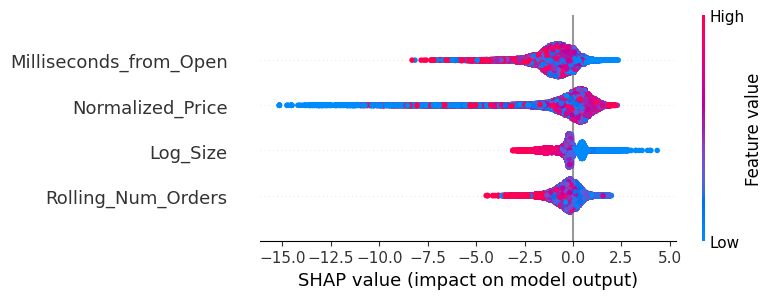

In [27]:
import shap

explainer = shap.Explainer(xg_clf)
shap_values = explainer(X)

# Shap plot
shap.summary_plot(shap_values, X, feature_names=features)

## Modified Weighted ANN Model

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



# Checking version and GPU on Kaggle Notebook
print("Using TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


2024-05-07 02:04:01.764699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 02:04:01.764809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 02:04:01.931518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow version: 2.15.0
GPU is available


In [31]:
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = combined_data[features].values
y = combined_data[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("Data split into training and testing sets.")


In [35]:
# Function to adjust the learning rate over epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

# normalized features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network architecture
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [40]:
# Model loss and metrics
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Model training callbacks
early_stopping = EarlyStopping(monitor='val_AUC', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_AUC', mode='max', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32,
                    callbacks=[early_stopping, checkpoint, lr_scheduler], verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5761 - accuracy: 0.9198 - loss: 0.2582 - precision: 0.0680 - recall: 0.0287
Epoch 1: val_AUC improved from -inf to 0.66198, saving model to best_model.keras
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.5761 - accuracy: 0.9198 - loss: 0.2582 - precision: 0.0680 - recall: 0.0287 - val_AUC: 0.6620 - val_accuracy: 0.9396 - val_loss: 0.2183 - val_precision: 0.4000 - val_recall: 0.0010 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
4067/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6317 - accuracy: 0.9437 - loss: 0.2109 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_AUC improved from 0.66198 to 0.66495, saving model to best_model.keras
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.6317 - accuracy: 0.9437 - loss: 0.2109 - precision: 0.0000e+00 - recall: 0.000

2190/2190 - 6s - 3ms/step - AUC: 0.7278 - accuracy: 0.9429 - loss: 0.1944 - precision: 0.4663 - recall: 0.0471
Test Loss: 0.1943969875574112, Test Accuracy: 0.9429129958152771, Test AUC: 0.7278373837471008, Test Precision: 0.46633416414260864, Test Recall: 0.047079555690288544


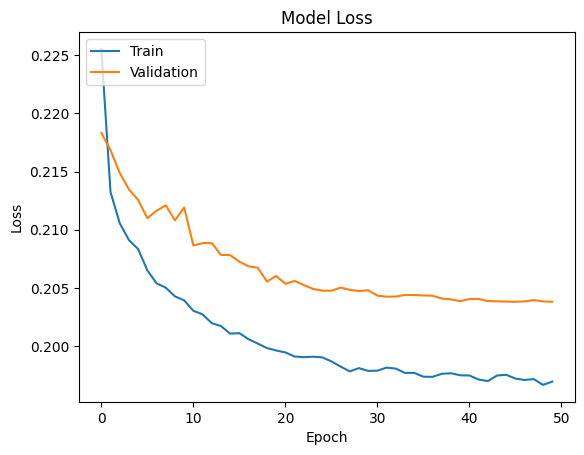

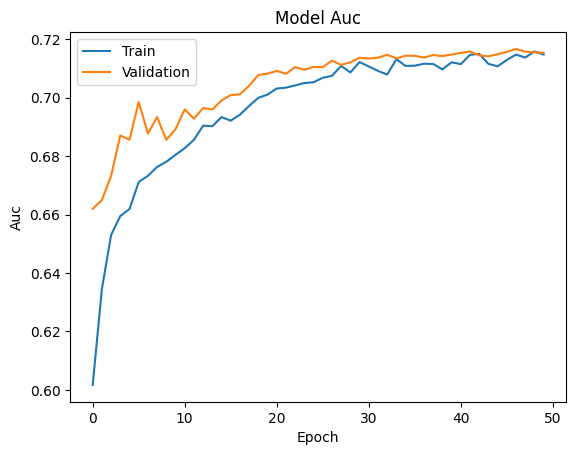

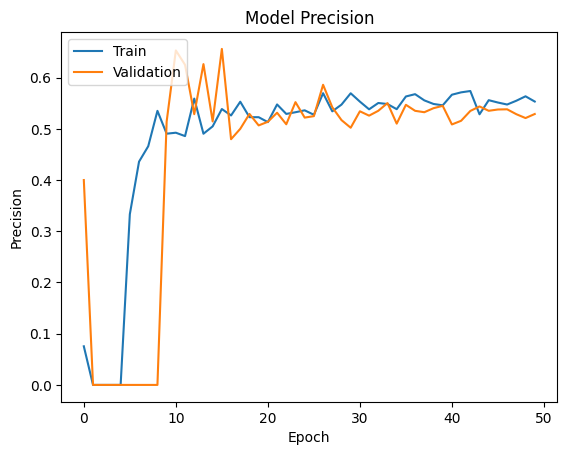

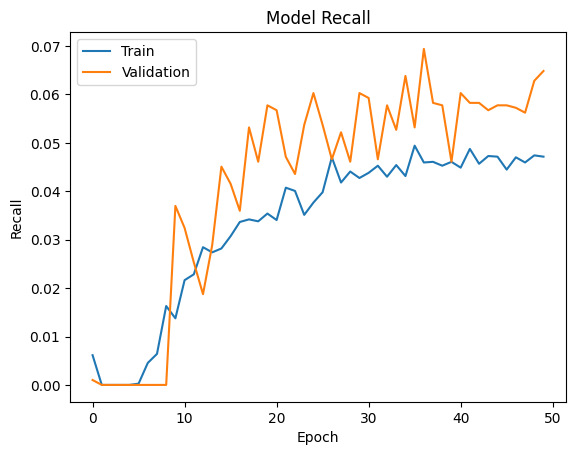

In [42]:

# Model Evaluation
best_model = tf.keras.models.load_model('best_model.keras')
test_results = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, Test AUC: {test_results[2]}, Test Precision: {test_results[3]}, Test Recall: {test_results[4]}')

# Metrics Plots
import matplotlib.pyplot as plt

metrics = ['loss', 'AUC', 'precision', 'recall']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## Weighted Logistic Regression + ANN

In [36]:
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = combined_data[features]
y = combined_data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

weighted_log_reg_model = LogisticRegression(class_weight=class_weights)

weighted_log_reg_model.fit(X_train, y_train)

y_train_pred_probs = weighted_log_reg_model.predict_proba(X_train)[:, 1]

# Predictict LogReg
y_pred = weighted_log_reg_model.predict(X_test)

# Results of LogReg
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.61      0.74     66079
           1       0.08      0.57      0.14      3972

    accuracy                           0.61     70051
   macro avg       0.52      0.59      0.44     70051
weighted avg       0.91      0.61      0.71     70051

Confusion Matrix:
 [[40159 25920]
 [ 1690  2282]]


In [37]:
# Neural network architecture
ann_model = Sequential([
    Input(shape=(X_train.shape[1] + 1,)),  # +1 for the logistic regression prediction
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
ann_model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

X_train_ann = np.hstack([X_train, y_train_pred_probs.reshape(-1, 1)])

early_stopping = EarlyStopping(monitor='val_AUC', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_AUC', mode='max', save_best_only=True, verbose=1)

# Model
history = ann_model.fit(X_train_ann, y_train, validation_split=0.2, epochs=50, batch_size=32,
                        callbacks=[early_stopping, checkpoint], verbose=1)

# Model Evaluation
best_hybrid_model = tf.keras.models.load_model('best_hybrid_model.keras')
y_test_pred_probs = weighted_log_reg_model.predict_proba(X_test)[:, 1]
X_test_ann = np.hstack([X_test, y_test_pred_probs.reshape(-1, 1)])
test_results = best_hybrid_model.evaluate(X_test_ann, y_test, verbose=2)
print(f'Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, Test AUC: {test_results[2]}')


Epoch 1/50
  70/4087 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.3966 - accuracy: 0.7377 - loss: 0.5422 - precision: 0.0241 - recall: 0.0817          

I0000 00:00:1715041098.215059     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5798 - accuracy: 0.9325 - loss: 0.2413 - precision: 0.0575 - recall: 0.0063
Epoch 1: val_AUC improved from -inf to 0.64666, saving model to best_hybrid_model.keras
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.5798 - accuracy: 0.9325 - loss: 0.2413 - precision: 0.0575 - recall: 0.0063 - val_AUC: 0.6467 - val_accuracy: 0.9384 - val_loss: 0.2206 - val_precision: 0.3248 - val_recall: 0.0193
Epoch 2/50
4067/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6315 - accuracy: 0.9421 - loss: 0.2151 - precision: 0.1637 - recall: 3.0498e-04
Epoch 2: val_AUC improved from 0.64666 to 0.65454, saving model to best_hybrid_model.keras
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.6315 - accuracy: 0.9421 - loss: 0.2151 - precision: 0.1640 - recall: 3.0479e-04 - val_AUC: 0.6545 - val_accuracy: 0.9396 - val_loss: 0.2183 - val_precision: 0.4000 - val_recall: 0.0010
Epoch 3/50
4078/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6375 - accuracy

## XGBoost + ANN

In [38]:
features = ['Milliseconds_from_Open', 'Rolling_Num_Orders', 'Normalized_Price', 'Log_Size']
target = 'Executed'

X = combined_data[features].values
y = combined_data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Counts for the scale_pos_weight parameter
count_neg, count_pos = np.bincount(y_train)

combined_xg_clf = xgb.XGBClassifier(scale_pos_weight=count_neg / count_pos)
combined_xg_clf.fit(X_train, y_train)
y_pred = combined_xg_clf.predict(X_test)
y_pred_proba = combined_xg_clf.predict_proba(X_test)[:, 1]

# Results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     66058
           1       0.22      0.81      0.34      3993

    accuracy                           0.82     70051
   macro avg       0.60      0.82      0.62     70051
weighted avg       0.94      0.82      0.87     70051

Confusion Matrix:
 [[54346 11712]
 [  754  3239]]
ROC AUC Score: 0.8985961456194227


In [40]:
# Predictions
y_train_pred = combined_xg_clf.predict_proba(X_train)[:, 1]
residuals = y_train - y_train_pred
X_train_with_residuals = np.hstack((X_train, residuals.reshape(-1, 1)))


In [41]:
# Normalize features including the residuals
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_residuals)
X_test_with_residuals = np.hstack((X_test, (y_test - combined_xg_clf.predict_proba(X_test)[:, 1]).reshape(-1, 1)))
X_test_scaled = scaler.transform(X_test_with_residuals)

# Neural network architecture
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Adjusted input shape for the extra residual feature
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [49]:
# Model evaluation metrics and loss
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Model checkpoint and scheduler
early_stopping = EarlyStopping(monitor='val_AUC', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_AUC', mode='max', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32,
                    callbacks=[early_stopping, checkpoint, lr_scheduler], verbose=1)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9763 - accuracy: 0.9562 - loss: 0.0984 - precision: 0.7038 - recall: 0.8421
Epoch 1: val_AUC improved from -inf to 0.99994, saving model to best_model.keras
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - AUC: 0.9763 - accuracy: 0.9562 - loss: 0.0984 - precision: 0.7038 - recall: 0.8421 - val_AUC: 0.9999 - val_accuracy: 0.9984 - val_loss: 0.0045 - val_precision: 0.9904 - val_recall: 0.9825 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
4066/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9974 - accuracy: 0.9962 - loss: 0.0117 - precision: 0.9719 - recall: 0.9630
Epoch 2: val_AUC did not improve from 0.99994
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.9974 - accuracy: 0.9962 - loss: 0.0117 - precision: 0.9719 - recall: 0.9630 - val_AUC: 0.9997 - val_accuracy: 0.9982 - val_l

2190/2190 - 5s - 2ms/step - AUC: 1.0000 - accuracy: 0.9999 - loss: 2.5172e-04 - precision: 1.0000 - recall: 0.9985
Test Loss: 0.00025171710876747966, Test Accuracy: 0.9999143481254578, Test AUC: 1.0, Test Precision: 1.0, Test Recall: 0.9984897971153259


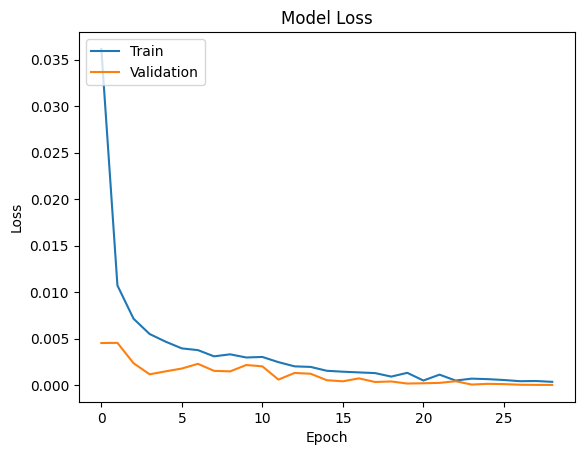

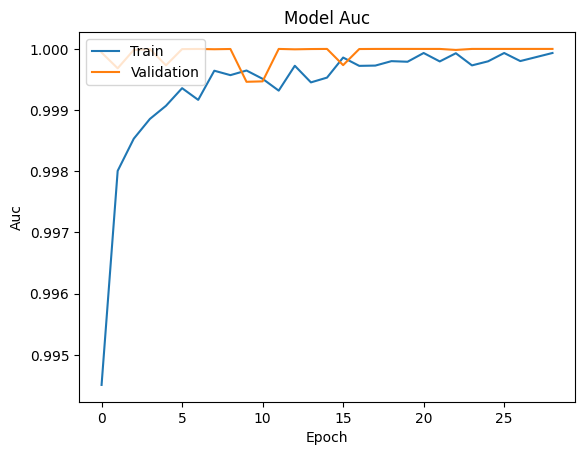

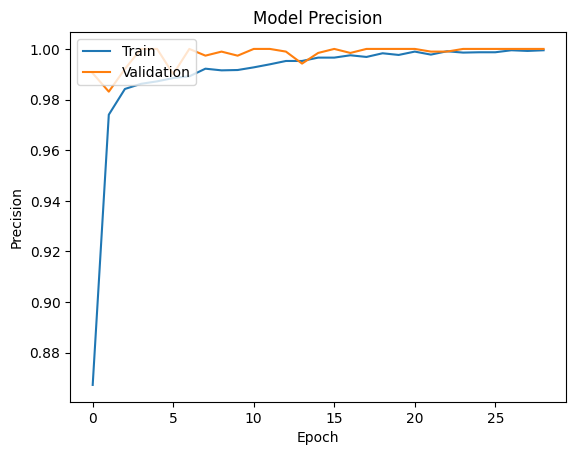

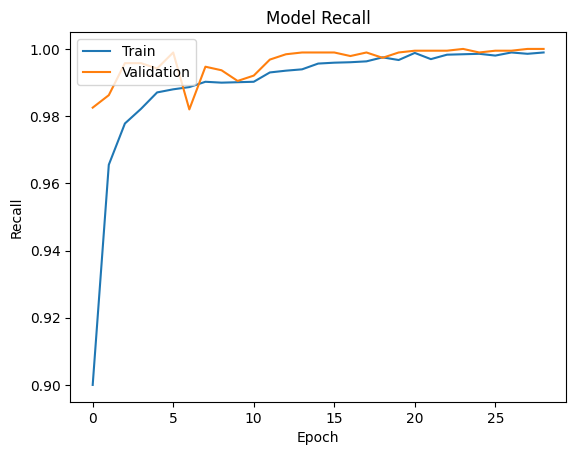

In [50]:

# Model Evaluation
best_model = tf.keras.models.load_model('best_model.keras')
test_results = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, Test AUC: {test_results[2]}, Test Precision: {test_results[3]}, Test Recall: {test_results[4]}')

# Metrics Plots for ensamble model
import matplotlib.pyplot as plt

metrics = ['loss', 'AUC', 'precision', 'recall']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()